<a href="https://colab.research.google.com/github/CGuzman99/ArXiv_IRS/blob/main/ArXiv_IRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Information Retrieval System of a subset of physics articles from the arXiv dataset (https://www.kaggle.com/datasets/Cornell-University/arxiv)

In [1]:
from google.colab import drive,files
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import math
import statistics
import random
import nltk
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import json


drive.mount("/content/gdrive")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive


# Def

In [2]:
def getCategories(item_cat, categories):
  lst_cat = []
  keys = categories.keys()
  for cat in keys:
    if cat in item_cat:
      lst_cat.append(categories[cat])
  return lst_cat

def print_info(index, itemdata, categories):
  item = itemdata[index]
  cat = getCategories(item["categories"], categories)
  print('Title:', item["title"])
  print('Authors:', item["authors"])
  print('Categories:', ", ".join(cat))
  print('Doi:', item["doi"])
  print(item["abstract"])
def print_info_lst(index_lst, itemdata, categories):
  for index in index_lst:
    print('----------------------------------------------')
    print_info(index, itemdata, categories)

In [3]:
#Intersection of two lists
def intersection(lst1, lst2):
  lst = [val for val in lst1 if val in lst2]
  return lst

#Union of two lists
def union(lst1, lst2):
  s1 = set(lst1)
  s2 = set(lst2)
  lst = list(s1.union(s2))
  lst.sort()
  return lst

#Transpose matrix
def traspuesta(matriz):
  tr = []
  for i in range(len(matriz[0])):
    x = [y[i] for y in matriz]
    tr.append(x)
  return tr

def sortDic(dic, rev=False):
  new_dic = {}
  keys = sorted(dic.keys(), reverse=rev)
  for key in keys:
    new_dic[key] = dic[key]
  return new_dic

def sortDicValues(dic, rev=False):
  new_dic = {}
  values = list(dic.items())
  values.sort(key=keySortItem, reverse=rev)
  for l,val in values:
    new_dic[l] = val
  return new_dic

def keySortItem(itm):
  return itm[1]

def graph(x, y, xlab, ylab, n):
  plt.subplot(2,1,n)
  plt.plot(x, y)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.show

#F measure with beta=1 (o alfa=1/2) as default
def F_measure(rec_prec, beta=1):
  F = {}
  b = pow(beta,2)
  for p,r in rec_prec.items():
    r = 0.5
    f = ((b+1)*p*r)/(b*p+r)
    F[p*100] = f*100
  sortDic(F)
  return F

def stdIndex(similarity):
  std = []
  for vector in similarity:
    std.append(statistics.pstdev(vector))
  aux = sorted(std, reverse=True)
  index = []
  for val in aux:
    ind = std.index(val)
    std.pop(ind)
    index.append(ind)
  return index, aux
    
def graphDistribution(similarity, doc):
  plt.hist(similarity[doc], bins=20)
  plt.plot()


## Tokenization, posting list

In [4]:
def remove_d(lst):
  data = []
  for string in lst:
    string = string.replace('Ñ', 'N')
    string = string.replace('Ü', 'U')
    data.append(''.join([s for s in string if not s.isdigit()]))
  return data

def tokenize(data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data)
  sw = set(stopwords.words('english'))
  tokens = list(tokenizer.word_index.keys())
  aux = []
  for token in tokens:
    if not token in sw:
      aux.append(token)
  aux.sort()
  tokens_rel = stemming(aux)
  tokens_index = tokenIndex(tokens_rel)
  return tokens_rel, tokens_index 

def stemming(tokens):
  stemmer = SnowballStemmer('english')
  tokens_rel = {}
  for token in tokens:
    word_st = stemmer.stem(token)
    if not word_st in tokens_rel.keys():
      tokens_rel[word_st] = []
    tokens_rel[word_st].append(token)
  return tokens_rel

def tokenIndex(tokens):
  ti = {}
  i = 0
  for token in tokens:
    ti[token] = i
    i += 1
  return ti

#Create posting list
def crearPL(tokens_rel, text):
  pl = []
  for token, words in tokens_rel.items():
    aux = []
    for word in words:
      for i in range(len(text)):
        if (word in text[i].lower()) and not (i in aux):
          aux.append(i)
    pl.append(aux)
  return pl

#Intersection between the posting list and the query words
def intersectionPL(words, pl, ti):
  word = ''
  while not (word in ti.keys()) and len(words)>0:
    word = words.pop(0)
  if not word in ti.keys():
    return []
  i = ti.get(word)
  lst = pl[i]
  for word in words:
    if word in ti.keys():
      i = ti[word]
      lst = intersection(lst, pl[i])
  return lst


##Query

In [5]:
#Query of a string
def query(query, pl, ti):
  string = query.upper()
  string = remove_d([string])
  q_tkr, q_tki = tokenize(string)
  words = list(q_tkr.keys())
  doc = intersectionPL(words, pl, ti)
  return doc,q_tkr

#Query of a list of strings: query=[string,...]
def query_lst(qr, pl, ti):
  doc = []
  q_tkr = {}
  for string in qr:
    lst,tkr = query(string, pl, ti)
    doc = union(doc, lst)
    for token in tkr:
      if not token in q_tkr.keys():
        q_tkr[token] = tkr[token]
        continue
      q_tkr[token] = union(q_tkr[token], tkr[token])
  return doc, q_tkr

#Query weighting
def queryWeighting(t_rel, q_tokens, query):
  string = ''
  if isinstance(query, str):
    string = query
  else:
    for cad in query:
      string = string + ' ' + cad
  q_tf = []
  q_idf = []
  q_weighting = [] 

  l = len(t_rel.keys())
  #tf, idf, tf-idf
  for i in range(l):
    q_tf.append(0)
    q_idf.append(0)
    token = list(t_rel.keys())[i]
    if token in q_tokens.keys():
      q_idf[i] = math.log(350,10)
      for word in q_tokens[token]:
        q_tf[i] += string.count(word)
    val = q_tf[i]*q_idf[i]
    q_weighting.append(val)
  return q_weighting

## Tf, df, idf, query weighting

In [6]:
#Term frequency
def termFrequency(data, tr):
  tf = []
  for term in tr:
    aux = []
    for i in range(len(data)):
      freq = 0
      row = data[i].lower()
      for word in tr[term]:
        freq += row.count(word)
      aux.append(freq)
    tf.append(aux)
  return tf

#Document frequency
def documentFreq(tf):
  df = []
  for vector in tf:
    freq = 0
    for f in vector:
      if (f>0):
        freq += 1
    df.append(freq)
  return df

#Inverse document frquency
def idf(df, n, log_base=math.e):
  idf = []
  x = 1
  for val in df:
    x = 1
    if val>0:
      x = n/val
    res = math.log(x, log_base)
    idf.append(res)
  return idf

#Tf-idf weighting
def tf_idfWeighting(tf, idf):
  tf_idf = []
  for j in range(len(tf)):
    aux = []
    for i in range(len(tf[j])):
      aux.append(tf[j][i]*idf[j])
    tf_idf.append(aux)
  return tf_idf

def docWeighting(l1,tokens_rel):
  tf = termFrequency(l1,tokens_rel)
  df = documentFreq(tf)
  _idf = idf(df, len(l1), log_base=10)
  tf_idf = tf_idfWeighting(tf, _idf)
  dc_weight = traspuesta(tf_idf)
  return dc_weight

##Compressing

In [7]:
def freqLetras(tokens):
  letras_fr = {}
  for i in range(97, 123):
    n = 0
    for token in tokens:
      n += token.count(chr(i))
    letras_fr[chr(i)] = n
  letras_fr = sortDicValues(letras_fr, rev=True)
  return letras_fr

#Code for compressing
def compressCode(letras):
  code = {}
  cad = '0'
  for l in letras:
    cad += '1'
    code[l] = cad
  return code

#Compress
def compress(tokens):
  letras_fr = freqLetras(tokens)
  letras = compressCode(letras_fr)
  cmp_string = ''
  for word in tokens:
    cmp_string += str(len(word))
    for w in word:
      if w in letras.keys():
        cmp_string += letras[w]
  return cmp_string

## Similarity

In [8]:
#Documents similarity
def similitud_doc(matriz):
  sim = []
  for v1 in matriz:
    v = []
    for v2 in matriz:
      val = similarity(v1, v2)
      v.append(val)
    sim.append(v)
  return sim

def similarity(v1, v2):
  dp = dot(v1,v2)
  n1 = norma(v1)
  n2 = norma(v2)
  sml = dp/(n1*n2)
  return sml

#Dot product between two vectors
def dot(v1, v2):
  dp = 0
  for i in range(len(v1)):
    dp += (v1[i]*v2[i])
  return dp

#Norm of a vector
def norma(vect):
  suma = 0
  for x in vect:
    suma += (x**2)
  return math.sqrt(suma)

#Order by similarity
def simSort(rtr, qw, mtr):
  dct = {}
  for i in rtr:
    vector = mtr[i]
    sim = similarity(qw, vector)
    dct[sim] = i
  dct = sortDic(dct, rev=True)
  return list(dct.values())

## Clustering 

In [9]:
#Create clusters using standard deviation
def clusteringSTD(simM, s):
  ctr = []
  clusters = []
  length = len(simM)
  std_index, std = stdIndex(simM)
  while len(std_index)>0:
    ind = std_index.pop(0)
    if inClusters(ind, clusters):
      continue
    clusters.append(createClusterS(ind, simM, s))
    ctr.append(ind)
  return clusters, ctr

#Create clusters
def clustering(smlM, s):
  ctr = []
  clusters = []
  length = len(smlM)
  for i in range(length):
    if not inClusters(i, clusters):
      clusters.append(createClusterS(i, smlM, s))
      ctr.append(i)
  return clusters, ctr

#Create cluster with n elements
def createClusterN(doc, dw, n):
  dic_sim = {}
  v_sim = dw[doc]
  for i in range(len(v_sim)):
    key = v_sim[i]
    dic_sim[key] = i
  dic_sim = sortDic(dic_sim, rev=True)
  cluster = [doc]
  values = list(dic_sim.values())
  for i in range(n-1):
    cluster.append(values[i])
  return cluster

#Create clustes with documents with similarity greater than or equal to s
def createClusterS(doc, sml, s):
  dic_sim = {}
  v_sim = sml[doc]
  for i in range(len(v_sim)):
    dic_sim[i] = v_sim[i]
  cluster = [doc]
  for i,val in dic_sim.items():
    if val>=s:
      cluster.append(i)
  return cluster

#Returns true if doc is in a cluster, and false otherwise
def inClusters(doc, clusters):
  for cluster in clusters:
    if doc in cluster:
      return True
  return False

#Returns de index of the cluster with it's main element as the most similar to doc
def getSimCluster(sml, ctr, doc):
  s = 0
  ind = 0
  for i in range(len(ctr)):
    c = ctr[i]
    if sml[doc][c]>s:
      s = sml[doc][c]
      ind = i
  return ind

#Returns a list of clusters most similar to the documents in docs
def getClusters(sml, ctr, docs):
  ind = []
  for doc in docs:
    i = getSimCluster(sml, ctr, doc)
    if i not in ind:
      ind.append(i)
  ind.sort()
  return ind

# Main code

In [10]:
itemdata = []
json_file = open('/content/gdrive/My Drive/arxiv-physics.json', 'r')
lines = json_file.readlines()
for line in lines:
  itemdata.append(json.loads(line))

In [11]:
ids = []
abstract = []
for item in itemdata:
  ids.append(item["id"])
  abstr = item["abstract"]
  abstract.append(abstr.upper())

In [12]:
categories = {
    'Physics' : ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph'],
    'Mathemathics' : ['math'],
    'Computer Science' : ['CoRR'],
    'Quantitative Biology' : ['q-bio'],
    'Quantitative Finance' : ['q-fin'],
    'Statistics' : ['stat'],
    'Electrical Engineering and Systems Science' : ['eess'],
    'Economics' : ['econ']
}
physics_subc = {
    'astro-ph' : 'Astrophysics', 
    'cond-mat' : 'Condensed Matter', 
    'gr-qc' : 'General Relativity and Quantum Cosmology', 
    'hep-ex' : 'High Energy Physics - Experiment', 
    'hep-lat' : 'High Energy Physcics - Lattice', 
    'hep-ph' : 'High Energy Physics - Phenomenology', 
    'hep-th' : 'High Energy Physics - Theory', 
    'math-ph' : 'Mathematical Physics', 
    'nlin' : 'Nonlinear Sciences', 
    'nucl-ex' : 'Nuclear Experiment', 
    'nucl-th' : 'Nuclear Theory', 
    'physics' : 'Physics', 
    'quant-ph' : 'Quantum Physics'
}


In [13]:
#Documents preprocessing
abstract2 = remove_d(abstract[:1000])
tokens_rel, tokens_index = tokenize(abstract2)
posting_list = crearPL(tokens_rel, abstract2)
tokens_cmp = compress(tokens_rel)

In [14]:
#Documents preprocessing
doc_weights = docWeighting(abstract2, tokens_rel)
sml = similitud_doc(doc_weights)

In [15]:
#Creates clusters
clusters,ctr = clustering(sml, 0.15)
#Creates clusters using standard deviation
clusters_std,ctr_std = clusteringSTD(sml, 0.15)

In [16]:
#Number of clusters
print(len(clusters))
print(len(clusters_std))

237
180


In [17]:
#Clusters intersection with cluster y
y = 100
for i in range(len(clusters)):
  inter = intersection(clusters[y], clusters[i])
  print(str(i)+':', len(inter))

0: 1
1: 0
2: 0
3: 0
4: 0
5: 1
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 1
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 0
34: 0
35: 1
36: 0
37: 0
38: 0
39: 0
40: 0
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 2
49: 0
50: 0
51: 0
52: 1
53: 0
54: 0
55: 0
56: 0
57: 0
58: 0
59: 0
60: 0
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 0
69: 0
70: 0
71: 0
72: 0
73: 0
74: 0
75: 0
76: 0
77: 0
78: 0
79: 0
80: 0
81: 0
82: 0
83: 0
84: 0
85: 0
86: 0
87: 0
88: 0
89: 0
90: 0
91: 0
92: 0
93: 0
94: 0
95: 0
96: 0
97: 0
98: 0
99: 0
100: 8
101: 0
102: 1
103: 0
104: 0
105: 0
106: 0
107: 0
108: 0
109: 0
110: 0
111: 0
112: 0
113: 0
114: 1
115: 0
116: 0
117: 0
118: 0
119: 0
120: 0
121: 0
122: 0
123: 1
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 0
133: 0
134: 0
135: 0
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 1
144: 0
145: 0
146: 0
147: 0
148: 0
149: 0
150: 0
151: 0
152: 0
153: 0
154: 0
155: 0
156: 0
157: 1
158:

In [18]:
#Clusters (made with the standard deviation) intersection with cluster y
y = 100
for i in range(len(clusters_std)):
  inter = intersection(clusters_std[y], clusters_std[i])
  print(str(i)+':', len(inter))

0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0
33: 0
34: 0
35: 0
36: 0
37: 0
38: 0
39: 0
40: 0
41: 0
42: 0
43: 0
44: 0
45: 0
46: 0
47: 0
48: 0
49: 0
50: 0
51: 0
52: 0
53: 0
54: 0
55: 1
56: 0
57: 0
58: 0
59: 0
60: 0
61: 0
62: 0
63: 0
64: 0
65: 0
66: 0
67: 0
68: 1
69: 0
70: 0
71: 0
72: 0
73: 0
74: 0
75: 0
76: 0
77: 0
78: 0
79: 0
80: 0
81: 0
82: 0
83: 0
84: 0
85: 0
86: 0
87: 0
88: 0
89: 0
90: 0
91: 0
92: 0
93: 0
94: 2
95: 0
96: 0
97: 0
98: 0
99: 1
100: 7
101: 0
102: 0
103: 0
104: 0
105: 0
106: 0
107: 0
108: 0
109: 0
110: 1
111: 0
112: 0
113: 0
114: 0
115: 0
116: 0
117: 0
118: 0
119: 0
120: 0
121: 0
122: 0
123: 0
124: 0
125: 0
126: 0
127: 0
128: 0
129: 0
130: 0
131: 0
132: 0
133: 0
134: 0
135: 0
136: 0
137: 0
138: 0
139: 0
140: 0
141: 0
142: 0
143: 0
144: 0
145: 0
146: 0
147: 0
148: 0
149: 0
150: 0
151: 0
152: 0
153: 0
154: 0
155: 0
156: 0
157: 0
158:

In [19]:
#Size of each cluster
for i in range(len(clusters_std)):
  print(str(i)+': '+str(len(clusters_std[i])))


0: 74
1: 6
2: 29
3: 24
4: 4
5: 15
6: 6
7: 6
8: 62
9: 17
10: 16
11: 7
12: 2
13: 12
14: 10
15: 8
16: 12
17: 40
18: 14
19: 2
20: 6
21: 19
22: 5
23: 7
24: 27
25: 24
26: 8
27: 14
28: 20
29: 16
30: 11
31: 14
32: 16
33: 3
34: 12
35: 15
36: 9
37: 16
38: 13
39: 16
40: 10
41: 6
42: 40
43: 6
44: 12
45: 10
46: 31
47: 9
48: 14
49: 7
50: 16
51: 11
52: 8
53: 17
54: 18
55: 16
56: 13
57: 8
58: 19
59: 20
60: 10
61: 5
62: 4
63: 16
64: 20
65: 4
66: 6
67: 4
68: 12
69: 10
70: 4
71: 25
72: 3
73: 23
74: 7
75: 4
76: 11
77: 4
78: 13
79: 3
80: 27
81: 5
82: 22
83: 11
84: 10
85: 14
86: 14
87: 15
88: 4
89: 12
90: 22
91: 4
92: 7
93: 24
94: 21
95: 9
96: 25
97: 8
98: 6
99: 6
100: 7
101: 12
102: 3
103: 9
104: 8
105: 27
106: 4
107: 15
108: 7
109: 10
110: 9
111: 6
112: 4
113: 11
114: 13
115: 2
116: 10
117: 3
118: 10
119: 37
120: 7
121: 6
122: 17
123: 9
124: 4
125: 11
126: 10
127: 3
128: 6
129: 7
130: 13
131: 2
132: 6
133: 7
134: 8
135: 11
136: 5
137: 7
138: 7
139: 17
140: 2
141: 10
142: 4
143: 4
144: 2
145: 10
146: 4
147

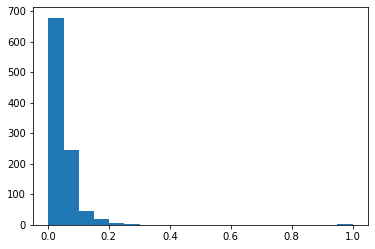

In [20]:
#Distribution from item x
x = 500
graphDistribution(sml, x)

In [21]:
#Cluster elements
for cluster in clusters_std:
  print(cluster)

[966, 13, 15, 78, 83, 84, 92, 106, 122, 123, 135, 165, 182, 183, 187, 189, 238, 246, 291, 301, 331, 341, 358, 364, 371, 377, 414, 421, 449, 451, 458, 460, 468, 469, 479, 511, 524, 531, 590, 599, 613, 618, 638, 640, 641, 644, 668, 688, 690, 695, 708, 709, 713, 716, 741, 753, 757, 816, 817, 825, 829, 864, 899, 904, 923, 929, 937, 943, 954, 964, 966, 973, 987, 999]
[922, 145, 414, 655, 680, 922]
[815, 111, 124, 144, 192, 202, 237, 265, 268, 332, 352, 375, 423, 454, 479, 509, 530, 577, 621, 642, 745, 769, 815, 918, 949, 955, 961, 975, 988]
[600, 77, 153, 180, 258, 279, 282, 314, 386, 410, 418, 492, 505, 597, 600, 616, 647, 661, 686, 829, 900, 915, 963, 987]
[932, 118, 827, 932]
[814, 18, 131, 327, 482, 555, 711, 750, 762, 787, 793, 814, 931, 978, 989]
[957, 150, 582, 617, 857, 957]
[920, 188, 614, 686, 830, 920]
[206, 17, 103, 121, 124, 149, 154, 157, 161, 168, 195, 198, 202, 206, 209, 220, 234, 241, 255, 265, 301, 310, 352, 361, 366, 370, 419, 423, 475, 478, 489, 498, 499, 509, 514, 526, 

In [22]:
#Example of query
retrieved, q_tkr = query('cosmology', posting_list, tokens_index)
print(retrieved)
print(abstract[retrieved[2]])

[3, 56, 100, 128, 139, 158, 170, 194, 239, 242, 254, 271, 280, 336, 356, 372, 392, 412, 437, 450, 502, 506, 521, 574, 590, 633, 664, 670, 684, 717, 762, 799, 811, 836, 875, 893, 947, 953, 52, 101, 163, 503, 591, 592, 631, 683, 705, 789, 872, 877]
  WE MODEL THE ESSENTIAL FEATURES OF ETERNAL INFLATION ON THE LANDSCAPE OF A
DENSE DISCRETUUM OF VACUA BY THE POTENTIAL $V(\PHI)=V_{0}+\DELTA V(\PHI)$,
WHERE $|\DELTA V(\PHI)|\LL V_{0}$ IS RANDOM. WE FIND THAT THE DIFFUSION OF THE
DISTRIBUTION FUNCTION $\RHO(\PHI,T)$ OF THE INFLATON EXPECTATION VALUE IN
DIFFERENT HUBBLE PATCHES MAY BE SUPPRESSED DUE TO THE EFFECT ANALOGOUS TO THE
ANDERSON LOCALIZATION IN DISORDERED QUANTUM SYSTEMS. AT $T \TO \INFTY$ ONLY THE
LOCALIZED PART OF THE DISTRIBUTION FUNCTION $\RHO (\PHI, T)$ SURVIVES WHICH
LEADS TO DYNAMICAL SELECTION PRINCIPLE ON THE LANDSCAPE. THE PROBABILITY TO
MEASURE ANY BUT A SMALL VALUE OF THE COSMOLOGICAL CONSTANT IN A GIVEN HUBBLE
PATCH ON THE LANDSCAPE IS EXPONENTIALLY SUPPRESSED AT $T\TO \

In [23]:
#Prints information of the results from de query
print_info_lst(retrieved, itemdata, physics_subc)

----------------------------------------------
Title: Polymer Quantum Mechanics and its Continuum Limit
Authors: Alejandro Corichi, Tatjana Vukasinac and Jose A. Zapata
Categories: General Relativity and Quantum Cosmology
Doi: 10.1103/PhysRevD.76.044016
  A rather non-standard quantum representation of the canonical commutation
relations of quantum mechanics systems, known as the polymer representation has
gained some attention in recent years, due to its possible relation with Planck
scale physics. In particular, this approach has been followed in a symmetric
sector of loop quantum gravity known as loop quantum cosmology. Here we explore
different aspects of the relation between the ordinary Schroedinger theory and
the polymer description. The paper has two parts. In the first one, we derive
the polymer quantum mechanics starting from the ordinary Schroedinger theory
and show that the polymer description arises as an appropriate limit. In the
second part we consider the continuum limi

In [24]:
#Clusters with it's main element most similar to documents in retrieved
sml_clusters = getClusters(sml, ctr_std, retrieved)
for index in sml_clusters:
  print(index)

0
11
12
13
24
29
35
42
44
45
52
53
54
57
59
60
71
73
74
82
89
94
103
105
119
133
135
136
157
171


In [25]:
#Prints information of the elements in one cluster
print_info_lst(clusters_std[sml_clusters[1]], itemdata, physics_subc)

----------------------------------------------
Title: Black hole puncture initial data with realistic gravitational wave
  content
Authors: Bernard J Kelly, Wolfgang Tichy, Manuela Campanelli, Bernard F Whiting
Categories: General Relativity and Quantum Cosmology
Doi: 10.1103/PhysRevD.76.024008
  We present improved post-Newtonian-inspired initial data for non-spinning
black-hole binaries, suitable for numerical evolution with punctures. We
revisit the work of Tichy et al. [W. Tichy, B. Bruegmann, M. Campanelli, and P.
Diener, Phys. Rev. D 67, 064008 (2003)], explicitly calculating the remaining
integral terms. These terms improve accuracy in the far zone and, for the first
time, include realistic gravitational waves in the initial data. We investigate
the behavior of these data both at the center of mass and in the far zone,
demonstrating agreement of the transverse-traceless parts of the new metric
with quadrupole-approximation waveforms. These data can be used for numerical
evolutio